### Code used for single cell data analysis and generation of anndata object
_Inhibition of LTβR-signalling blocks epithelial apoptosis and activates Wnt-induced regeneration in lung_ <br> Thomas M Conlon, Mathias Heikenwälder et. al and Ali Yildirim

In [1]:
## This Notebook is based on the anndata object generated in Fig1_preprocess_generate_object.ipynb
## Generates Supplementary Figure S2 a, b

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
folder = "/20200525_Yildirim_6mSmokedMiceLTbeta_meshal.ansari/"

sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.5.2.dev28+gb910afc6, on 2020-07-06 14:05.


In [2]:
sc.settings.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)
sb.set_style("ticks")

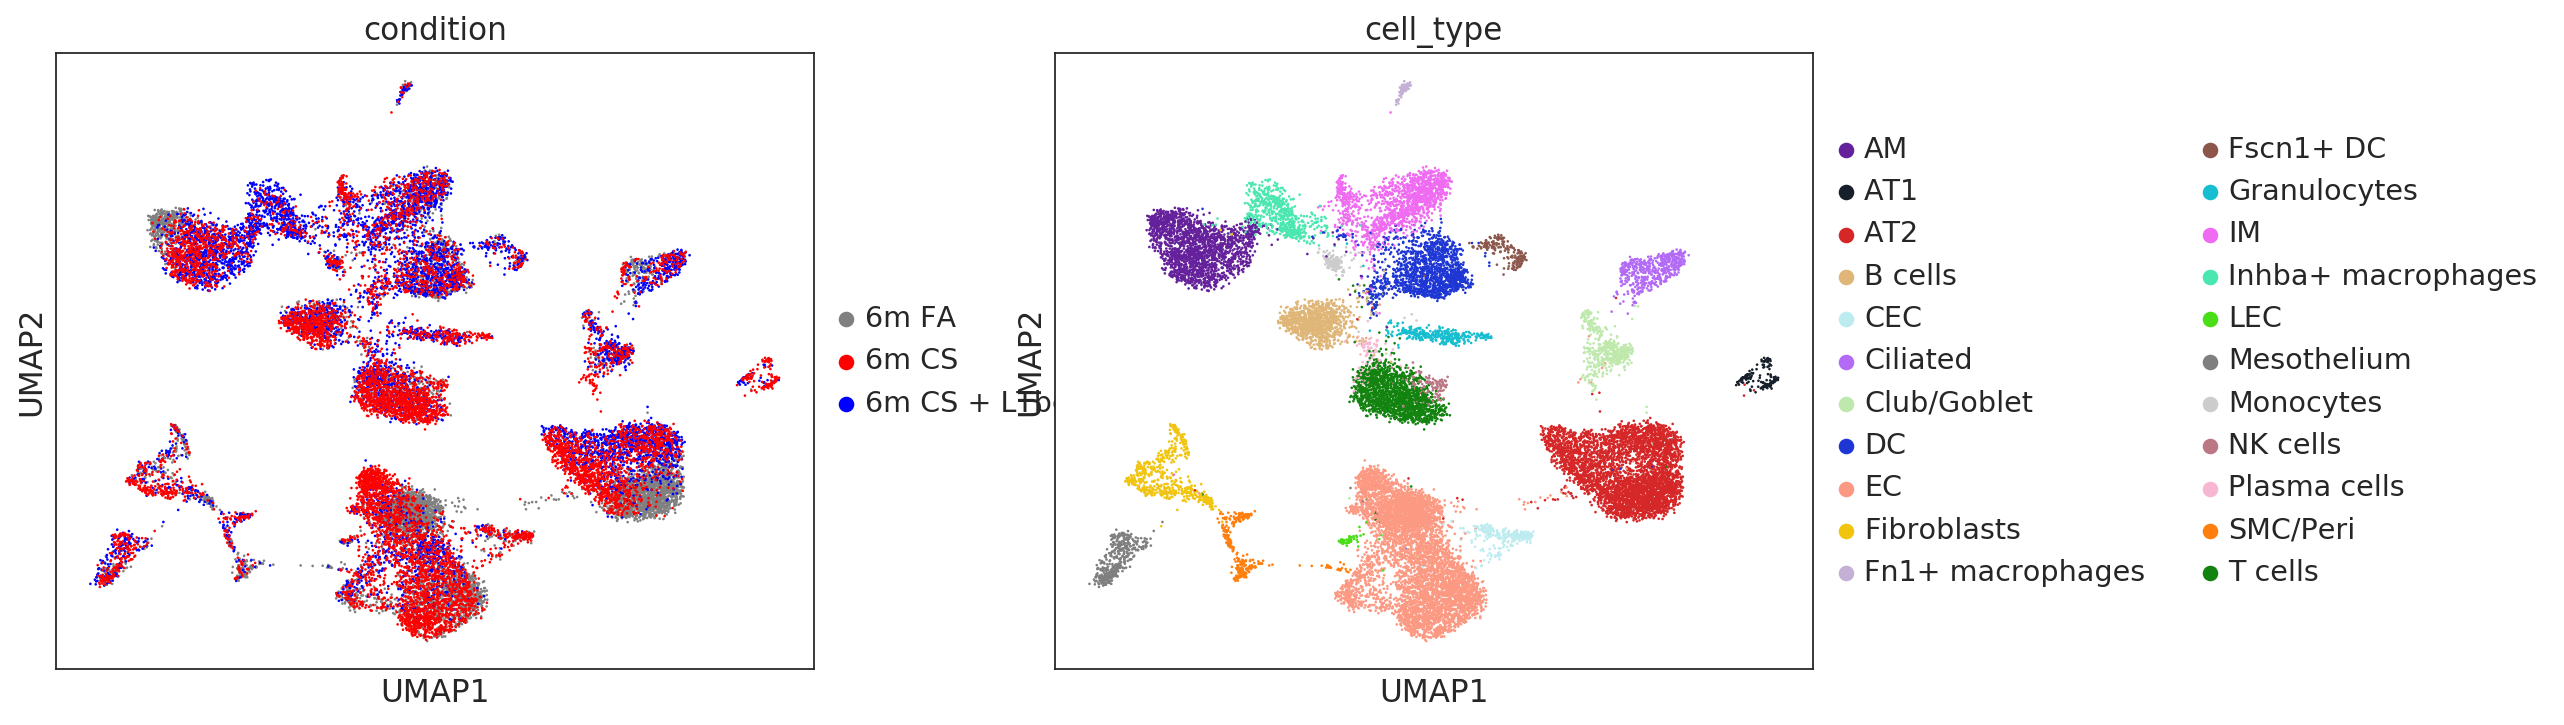

In [3]:
adata = sc.read(folder + "6m_smoked_mice_LTbeta_treatment.h5ad")
sc.pl.umap(adata, color = ["condition", "cell_type"], wspace = 0.2)

### Fig S2 a) Cell Type Marker Overview

In [5]:
marker = pd.read_csv(folder + "LTbetaTreatment_celltype_markers.txt", sep = "\t", decimal = ",")
marker.head()

,gene,score,logfoldchange,pval,pval_adj,cluster
0,Chil3,68.578316,4.854106,0.0,0.0,AM
1,Ctsd,66.327568,3.498977,0.0,0.0,AM
2,Ccl6,64.974518,3.861902,0.0,0.0,AM
3,Atp6v0d2,51.395203,4.122636,0.0,0.0,AM
4,Ctss,50.604614,2.440143,0.0,0.0,AM


    using 'X_pca' with n_pcs = 60
Storing dendrogram info using `.uns['dendrogram_cell_type']`
    using 'X_pca' with n_pcs = 60
Storing dendrogram info using `.uns["dendrogram_['cell_type']"]`


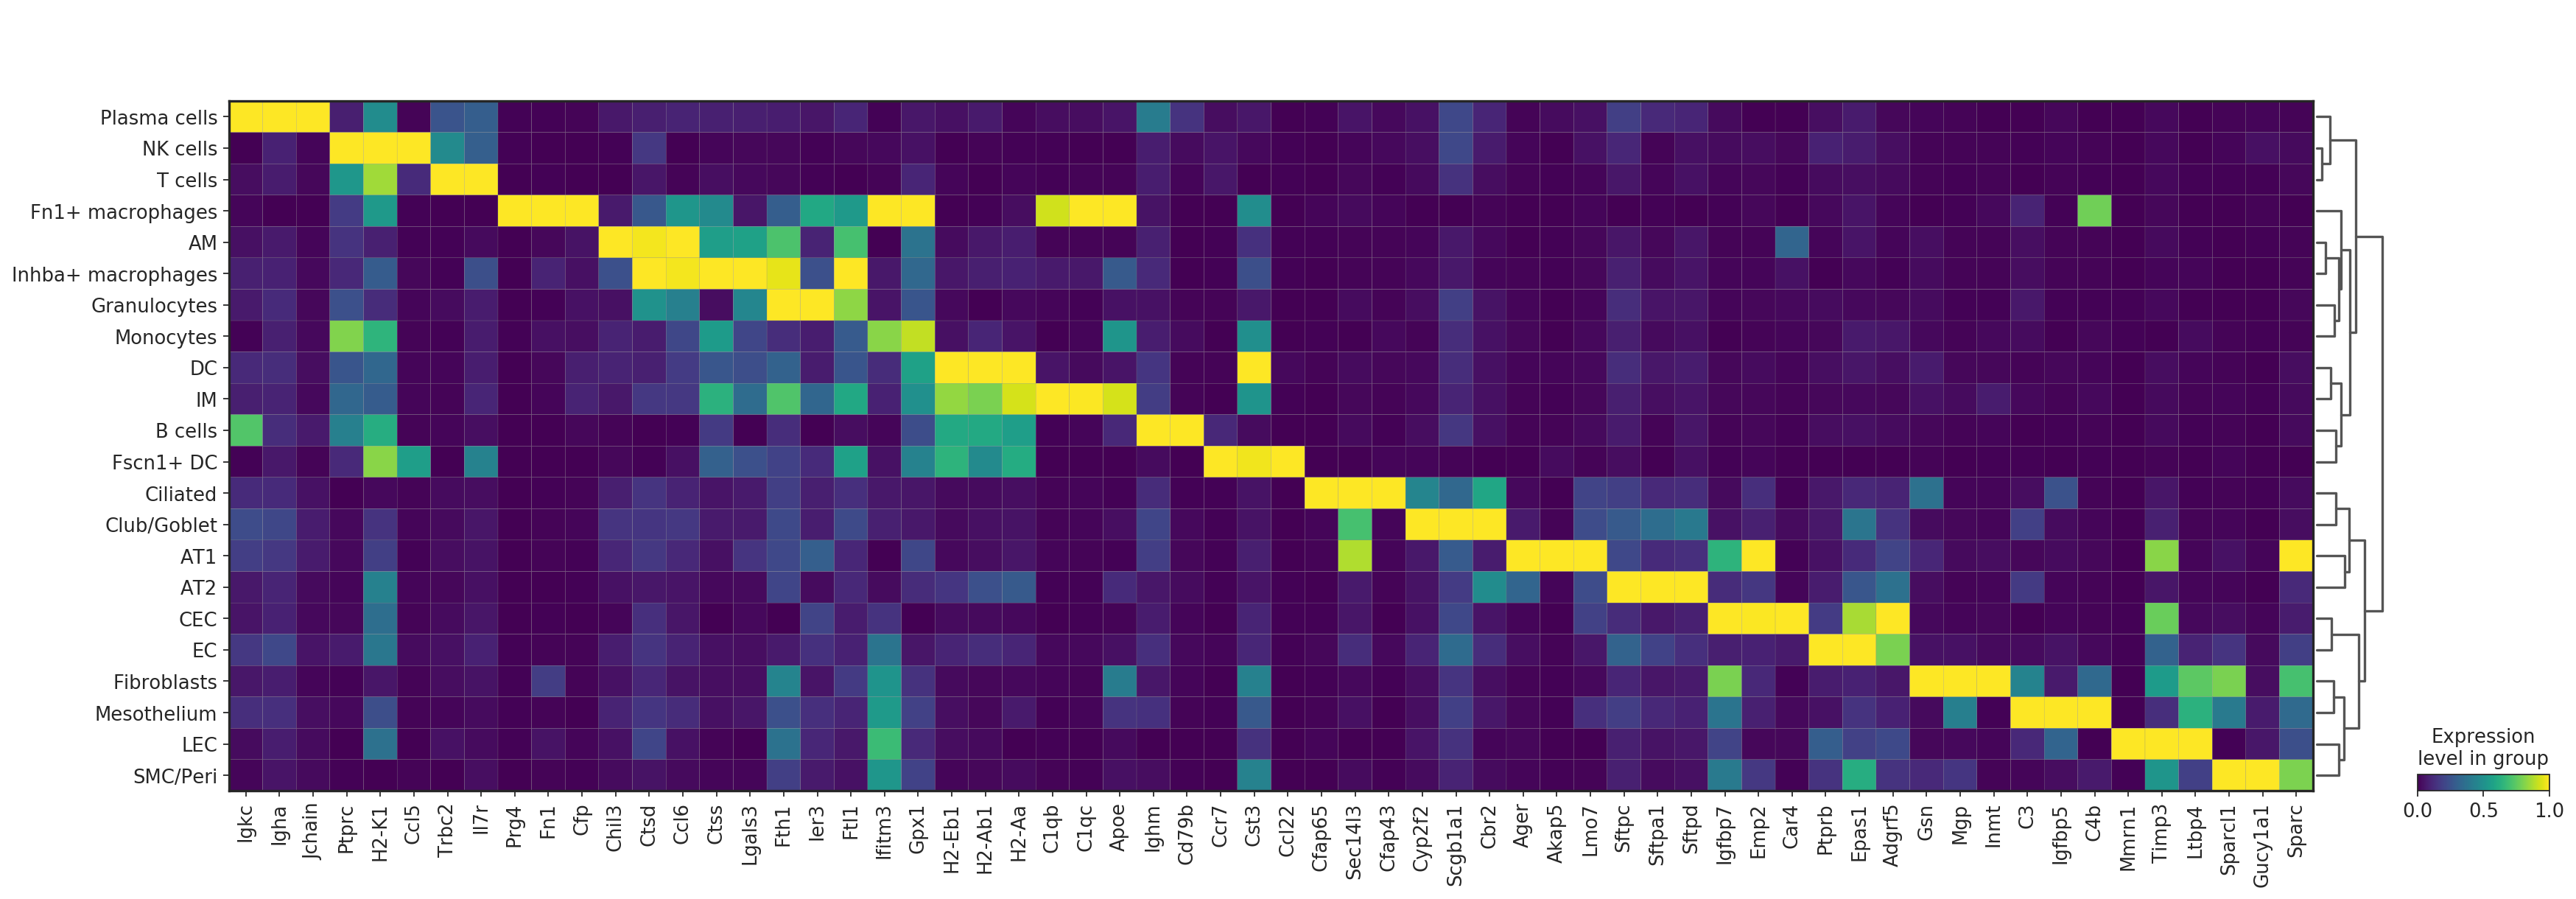

In [6]:
## Use 3 top markers (unique) for each cell type based on score column
sc.tl.dendrogram(adata, groupby = "cell_type", key_added = "dendrogram_cell_type")
order = adata.uns["dendrogram_cell_type"]["dendrogram_info"]["ivl"]

n_genes = 3
genes = []
for typ in order:
    curgenes = marker.loc[marker.cluster == typ, "gene"].values[0:n_genes]
    genes = genes + [g for g in curgenes if g not in genes]
    
sc.pl.matrixplot(adata, var_names = genes, standard_scale = "var", groupby = "cell_type", dendrogram = True)

### Fig S2 b) Dot plot overview of genes of interest

In [7]:
rename_map = {"6m FA": "FA", "6m CS": "CS + lg", "6m CS + LTbeta": "CS + LTβR-lg"}
adata.obs["condition"] = [rename_map[cond] for cond in adata.obs.condition]
adata.obs["cell_type_condition"] = adata.obs.loc[:, ["cell_type", "condition"]].agg(" ".join, axis = 1)
sc._utils.sanitize_anndata(adata)

## Set order of condition
order = []
for ct in adata.obs["cell_type"].cat.categories:
    for d in ["FA", "CS + lg", "CS + LTβR-lg"]:
        order.append("%s %s" %(ct, d))
adata.obs.cell_type_condition.cat.reorder_categories(order, inplace = True)

... storing 'condition' as categorical
... storing 'cell_type_condition' as categorical


In [8]:
## Check percentage of expressing cells for each gene per celltype condition combination

def add_pct(a, tab, ids, group_by, thresh_min = 0, gene_label = "gene"):
    for ident in ids:
        cells = adata.obs_names[a.obs[group_by] == ident]
        data_temp = pd.DataFrame(((a[cells].layers["counts"] > 0).sum(0) / a[cells].layers["counts"].shape[0]).T,
                                 index = a.var_names)
        tab["pct.%s" %ident] = data_temp.loc[tab.index.values].values
        
    return tab

genes =  ["Lta", "Ltb", "Tnfsf14", "Tnf", "Ltbr", "Tnfrsf14", "Tnfrsf1a", "Tnfrsf1b" ]
tab = pd.DataFrame(index = genes)
tab = add_pct(adata, tab = tab, group_by = "cell_type_condition", gene_label = "index", 
                    ids = adata.obs.cell_type_condition.cat.categories.values)
tab

,pct.AM FA,pct.AM CS + lg,pct.AM CS + LTβR-lg,pct.AT1 FA,pct.AT1 CS + lg,pct.AT1 CS + LTβR-lg,pct.AT2 FA,pct.AT2 CS + lg,pct.AT2 CS + LTβR-lg,pct.B cells FA,...,pct.NK cells CS + LTβR-lg,pct.Plasma cells FA,pct.Plasma cells CS + lg,pct.Plasma cells CS + LTβR-lg,pct.SMC/Peri FA,pct.SMC/Peri CS + lg,pct.SMC/Peri CS + LTβR-lg,pct.T cells FA,pct.T cells CS + lg,pct.T cells CS + LTβR-lg
Lta,0.002519,0.004666,0.001058,0.0,0.000000,0.000000,0.001281,0.002247,0.001770,0.009091,...,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.012346,0.019704,0.030632,0.041068
Ltb,0.002519,0.009331,0.008466,0.0,0.009346,0.000000,0.003203,0.006742,0.004425,0.045455,...,0.000000,0.000000,0.045455,0.025641,0.007576,0.011364,0.000000,0.049261,0.176877,0.117043
Tnfsf14,0.000000,0.004666,0.004233,0.0,0.000000,0.000000,0.001922,0.004494,0.005310,0.000000,...,0.000000,0.111111,0.045455,0.025641,0.000000,0.011364,0.000000,0.049261,0.113636,0.112936
Tnf,0.163728,0.074650,0.053968,0.0,0.000000,0.000000,0.001281,0.004494,0.007080,0.027273,...,0.230769,0.000000,0.068182,0.025641,0.000000,0.011364,0.000000,0.049261,0.078063,0.086242
Ltbr,0.108312,0.130638,0.071958,0.0,0.168224,0.147059,0.051890,0.155056,0.092035,0.000000,...,0.000000,0.000000,0.022727,0.025641,0.083333,0.045455,0.086420,0.009852,0.004941,0.010267
Tnfrsf14,0.000000,0.000000,0.000000,0.0,0.018692,0.000000,0.000641,0.005993,0.001770,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004941,0.008214
Tnfrsf1a,0.113350,0.133748,0.083598,0.0,0.037383,0.000000,0.039718,0.122846,0.064602,0.018182,...,0.000000,0.000000,0.022727,0.025641,0.136364,0.238636,0.172840,0.034483,0.029644,0.018480
Tnfrsf1b,0.130982,0.188180,0.121693,0.0,0.009346,0.029412,0.007687,0.032959,0.022124,0.018182,...,0.000000,0.000000,0.022727,0.051282,0.015152,0.022727,0.024691,0.014778,0.084980,0.112936


In [9]:
## Plot gene for each group in which it is expressed in at least 10 percent of cells
thresh = 0.1
rel_cts = {'Lta': ['B cells', 'T cells']}

for gene in genes:
    for celltype in adata.obs.cell_type.cat.categories:
        tmp = tab.filter(like = celltype).loc[gene].values
        if sum(tmp > thresh) > 1:
            if gene in rel_cts.keys(): #) and (celltype not in rel_cts[gene]):
                rel_cts[gene] = rel_cts[gene] + [celltype]
            else:
                rel_cts[gene] = [celltype]
            
rel_cts

{'Lta': ['B cells', 'T cells'],
 'Ltb': ['B cells', 'T cells'],
 'Tnfsf14': ['Granulocytes', 'T cells'],
 'Tnf': ['Granulocytes', 'IM', 'Inhba+ macrophages'],
 'Ltbr': ['AM',
  'AT1',
  'AT2',
  'CEC',
  'Ciliated',
  'EC',
  'Fibroblasts',
  'LEC',
  'SMC/Peri'],
 'Tnfrsf1a': ['AM',
  'CEC',
  'EC',
  'Fibroblasts',
  'Fn1+ macrophages',
  'Granulocytes',
  'IM',
  'Inhba+ macrophages',
  'Mesothelium',
  'Monocytes',
  'SMC/Peri'],
 'Tnfrsf1b': ['AM',
  'DC',
  'Fn1+ macrophages',
  'Fscn1+ DC',
  'Granulocytes',
  'IM',
  'Inhba+ macrophages',
  'Monocytes',
  'T cells']}

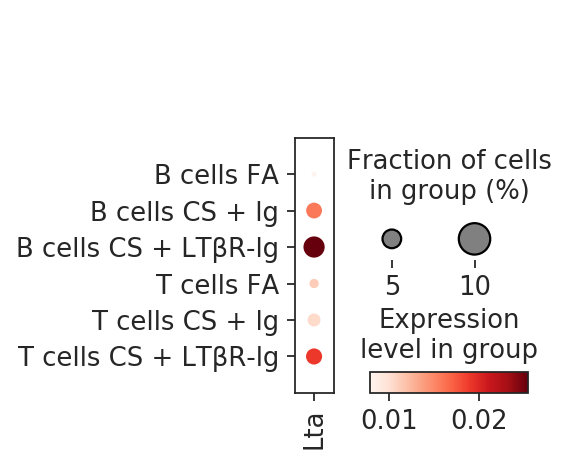

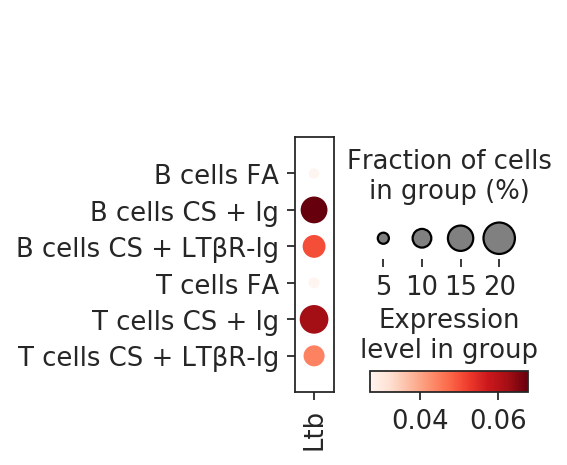

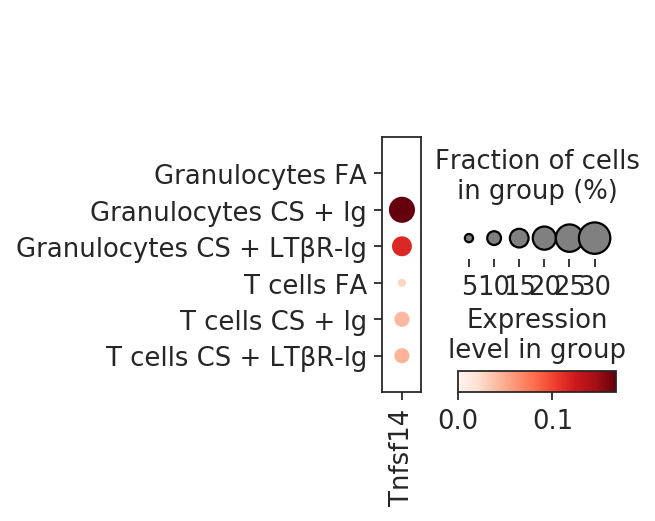

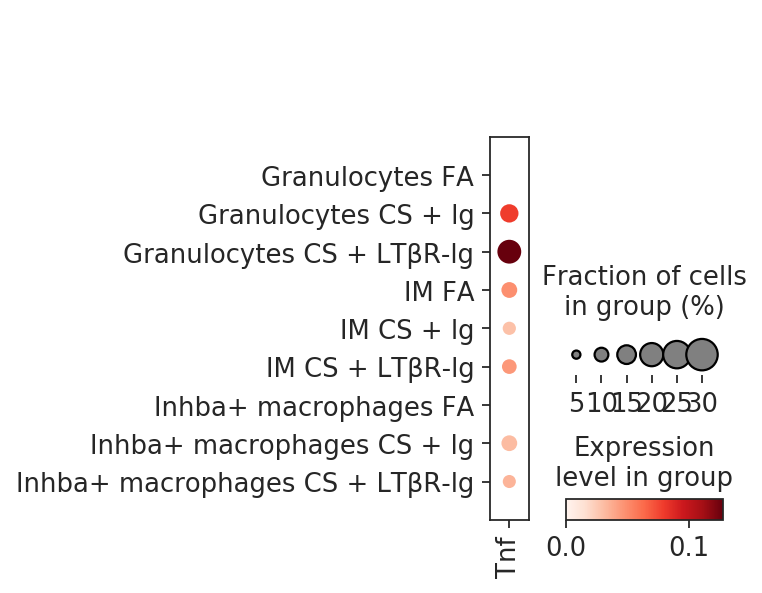

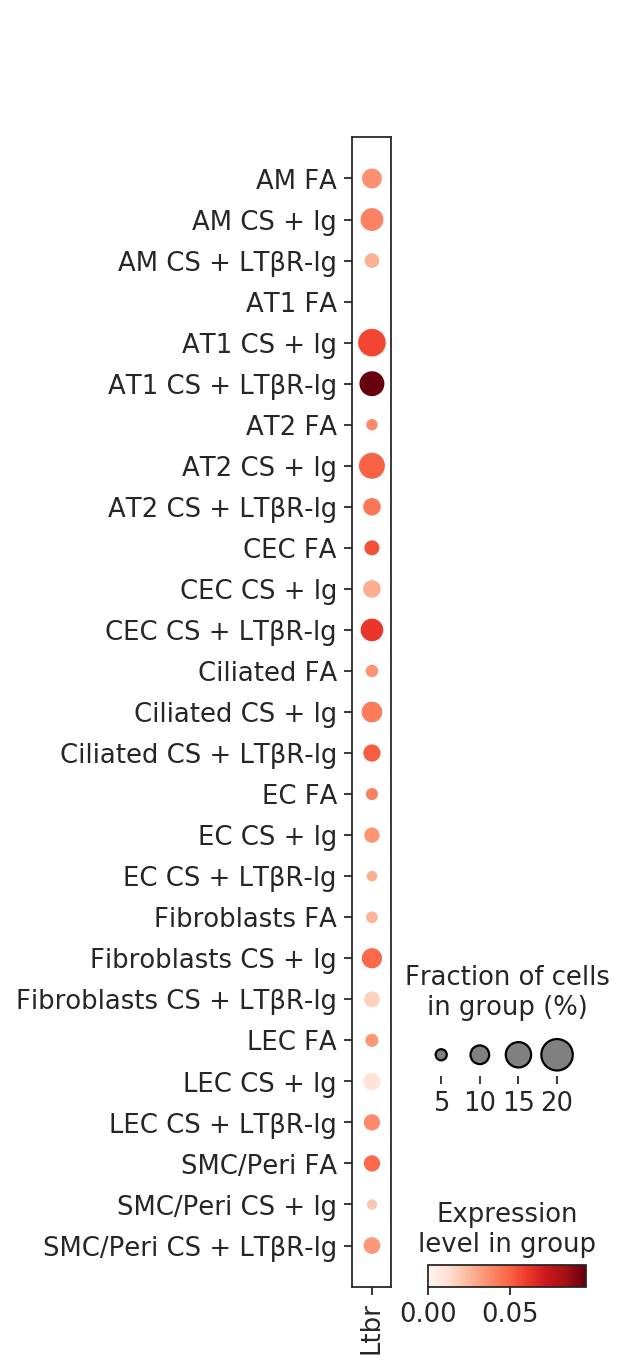

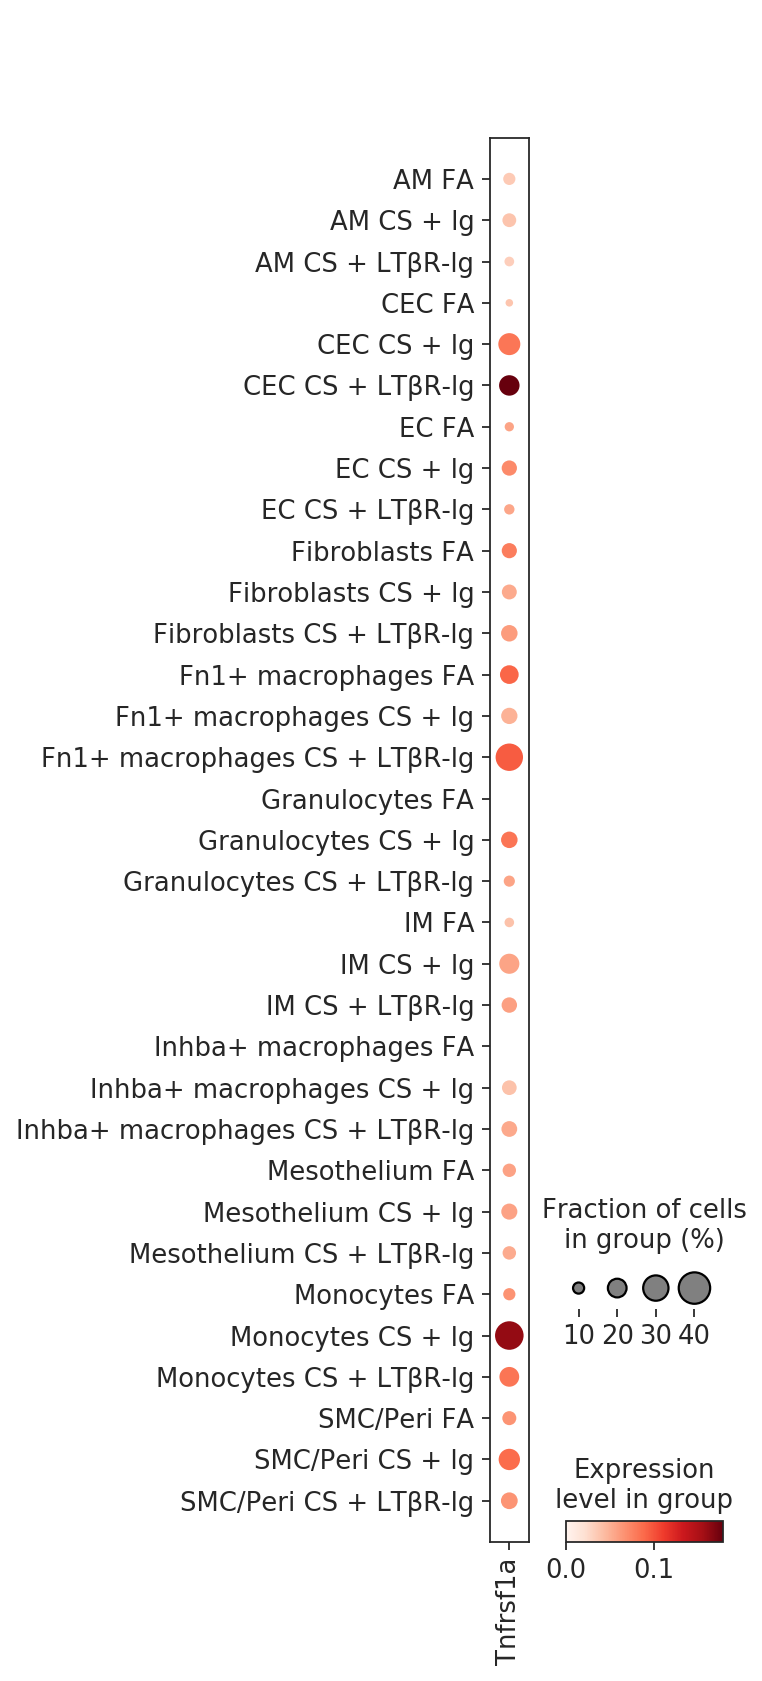

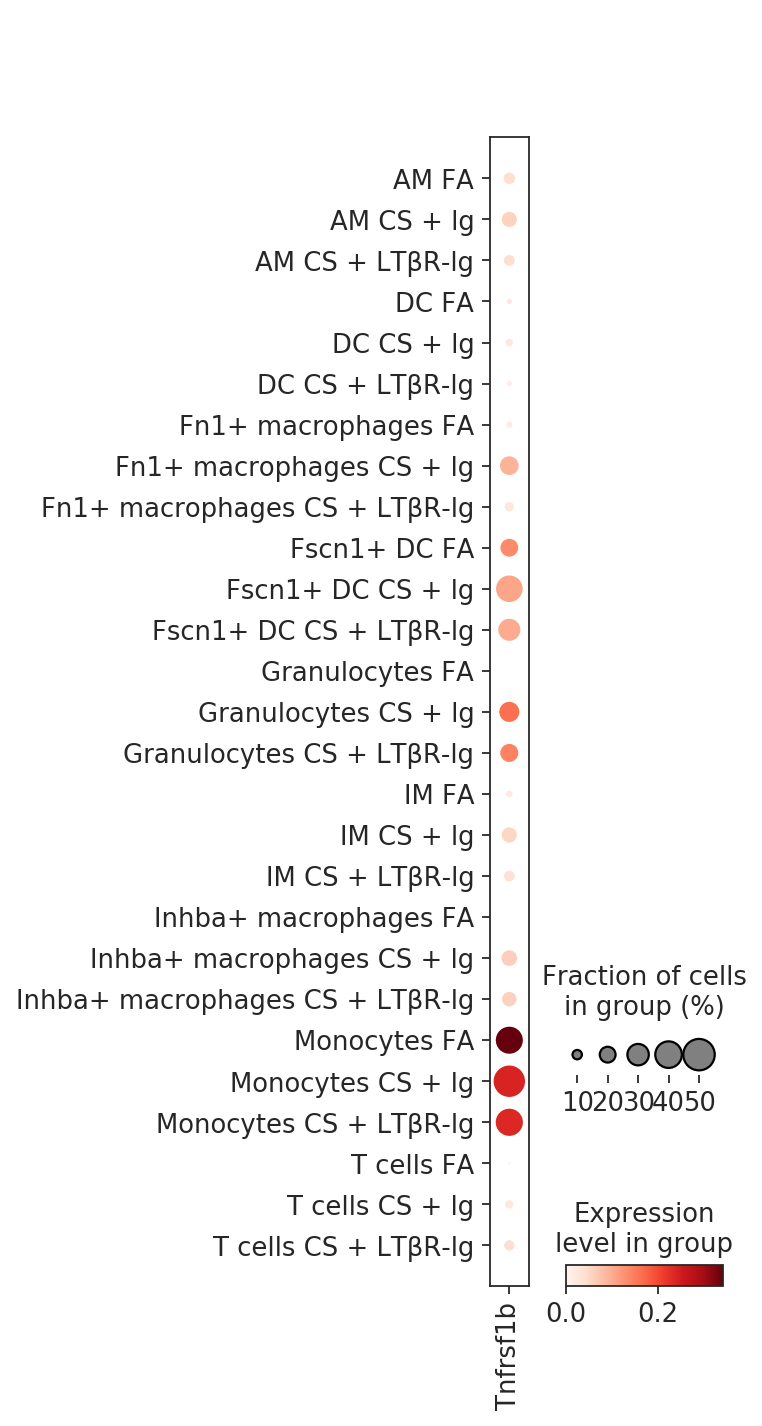

In [10]:
for gene in rel_cts.keys():
    cells = adata.obs.cell_type.isin(rel_cts[gene])
    sc.pl.dotplot(adata[cells], var_names = gene, groupby = "cell_type_condition")  